#### Transfer learning - Image Classification

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow_hub as hub

import PIL
import cv2
import os

In [4]:
# Import Pre-trained Model from tensorflow
IMAGE_SHAPE = (224, 224)
classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

In [21]:
import pathlib
# Loading flower dataset 
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, cache_dir='.', untar=True)
data_dir = pathlib.Path(data_dir)
# Preprocessing the data - similar to data augmentation example
flowers_dir_mapping = {
    'daisy': {
        "label": 0,
        "dir": list(data_dir.glob('daisy/*')),
    },
    'dandelion': {
        "label": 1,
        "dir": list(data_dir.glob('dandelion/*')),
    },
    'roses': {
        "label": 2,
        "dir": list(data_dir.glob('roses/*')),
    },
    'sunflowers': {
        "label": 3,
        "dir": list(data_dir.glob('sunflowers/*')),
    },
    'tulips': {
        "label": 4,
        "dir": list(data_dir.glob('tulips/*')),
    }
}

x_data = []
y_data = []
for flower_name, data in flowers_dir_mapping.items():
    for img_path in data['dir']:
        img = cv2.imread(str(img_path))
        img_resized = cv2.resize(img, IMAGE_SHAPE)
        x_data.append(img_resized)
        y_data.append(data['label'])

x_data_n = np.array(x_data)
y_data_n = np.array(y_data)

# Train Test Split and Preprocessing
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data_n, y_data_n, test_size=0.2, random_state=42)

x_train_scaled = x_train.astype('float32') / 255.0
x_test_scaled = x_test.astype('float32') / 255.0

Making Predictions using a pre-trained model and a new dataset (flowers).

In [22]:
# Loading Image Labels
image_labels = []
with open("ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
    
image_labels = np.array(image_labels)

In [23]:
img_resized_1 = cv2.resize(x_data[9], IMAGE_SHAPE)
img_resized_2 = cv2.resize(x_data[45], IMAGE_SHAPE)
pred = classifier.predict(np.array([img_resized_1, img_resized_2])/255.0)
pred_labels = np.argmax(pred, axis=1)
image_labels[pred_labels]

array(['daisy', 'daisy'], dtype='<U30')

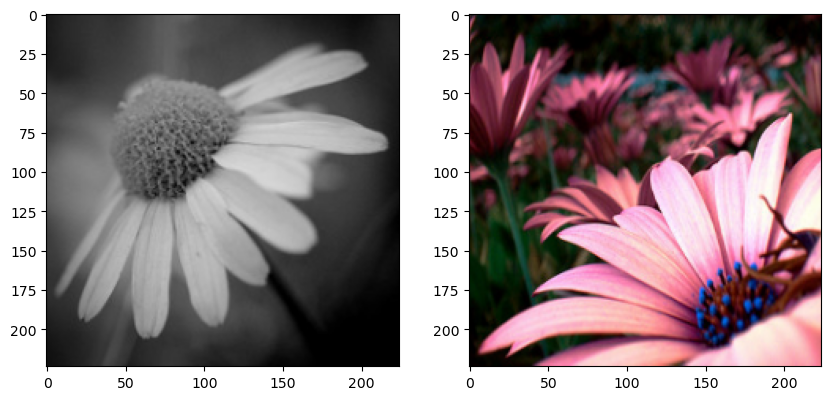

In [24]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(x_data[9])
plt.subplot(1,2,2)
plt.imshow(x_data[45])
plt.show()

Training Pre-trained Model on Flower Dataset

In [25]:
# classes
classes = 5

# Requesting model without the classification layer (top layer)
feature_extractor_model_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model_url, input_shape=IMAGE_SHAPE + (3,), trainable=False
)

# Creating new model by adding a new classification layer to the pre-trained model
model = tf.keras.Sequential([
    pretrained_model_without_top_layer,
    tf.keras.layers.Dense(classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
model.fit(x_train_scaled, y_train, epochs=15)

Epoch 1/15
92/92 [==============================] - 6s 60ms/step - loss: 0.2003 - accuracy: 0.9448
Epoch 2/15
92/92 [==============================] - 6s 60ms/step - loss: 0.1789 - accuracy: 0.9530
Epoch 3/15
92/92 [==============================] - 5s 59ms/step - loss: 0.1590 - accuracy: 0.9615
Epoch 4/15
92/92 [==============================] - 5s 60ms/step - loss: 0.1450 - accuracy: 0.9653
Epoch 5/15
92/92 [==============================] - 6s 60ms/step - loss: 0.1340 - accuracy: 0.9704
Epoch 6/15
92/92 [==============================] - 6s 60ms/step - loss: 0.1218 - accuracy: 0.9724
Epoch 7/15
92/92 [==============================] - 6s 61ms/step - loss: 0.1087 - accuracy: 0.9816
Epoch 8/15
92/92 [==============================] - 5s 60ms/step - loss: 0.0962 - accuracy: 0.9857
Epoch 9/15
92/92 [==============================] - 6s 60ms/step - loss: 0.0888 - accuracy: 0.9888
Epoch 10/15
92/92 [==============================] - 6s 60ms/step - loss: 0.0819 - accuracy: 0.9884
Epoch 11/

In [29]:
model.evaluate(x_test_scaled, y_test)

23/23 [==============================] - 1s 60ms/step - loss: 0.3890 - accuracy: 0.8638


[0.38897809386253357, 0.863760232925415]

In [30]:
# classification report & confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
def print_report(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=flowers_dir_mapping.keys(),
                yticklabels=flowers_dir_mapping.keys())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       150
           1       0.86      0.94      0.90       166
           2       0.84      0.83      0.83       132
           3       0.87      0.85      0.86       129
           4       0.86      0.84      0.85       157

    accuracy                           0.86       734
   macro avg       0.86      0.86      0.86       734
weighted avg       0.86      0.86      0.86       734



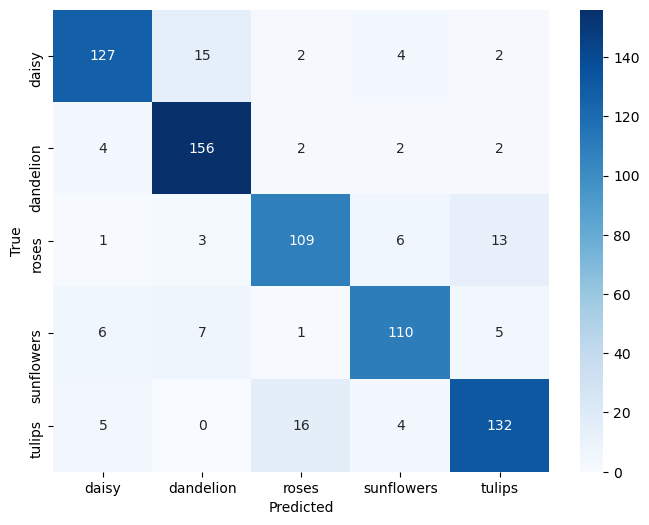

In [32]:
y_pred = model.predict(x_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
print_report(y_test, y_pred_classes)
# We have seen more accuracy than data augmentation method